In [223]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [224]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index
df.head()

78


,,country,district_code,centx,centy,year_month,year,month,ipc,ha,ndvi_mean,...,et_mean,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct
date,district,,,,,,,,,,,,,,,,,,,,,
2007-01-01,Bor,South Sudan,74,32.00486,6.465644,2007_01,2007,1,NaN,NaN,0.345851,...,0.671249,0.048880,0,0,0.561363,14008.33,7.961984,239344.0,11393.76,90.8503
2007-02-01,Bor,South Sudan,74,32.00486,6.465644,2007_02,2007,2,NaN,NaN,0.307600,...,0.129184,-0.457928,0,0,0.565693,14008.33,7.961984,239344.0,11393.76,90.8503
2007-03-01,Bor,South Sudan,74,32.00486,6.465644,2007_03,2007,3,NaN,NaN,0.278344,...,1.025460,-0.590175,0,0,0.592437,14008.33,7.961984,239344.0,11393.76,90.8503
2007-04-01,Bor,South Sudan,74,32.00486,6.465644,2007_04,2007,4,NaN,NaN,0.303320,...,3.846809,-1.845536,0,0,0.605352,14008.33,7.961984,239344.0,11393.76,90.8503
2007-05-01,Bor,South Sudan,74,32.00486,6.465644,2007_05,2007,5,NaN,NaN,0.413716,...,8.316274,-2.972735,0,0,0.618699,14008.33,7.961984,239344.0,11393.76,90.8503


C:\Users\20203171\AppData\Local\Temp\ipykernel_10652\3602418209.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  missing_values_per_year.append(len(df[df['ipc'].isna()][df['year']==i]))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


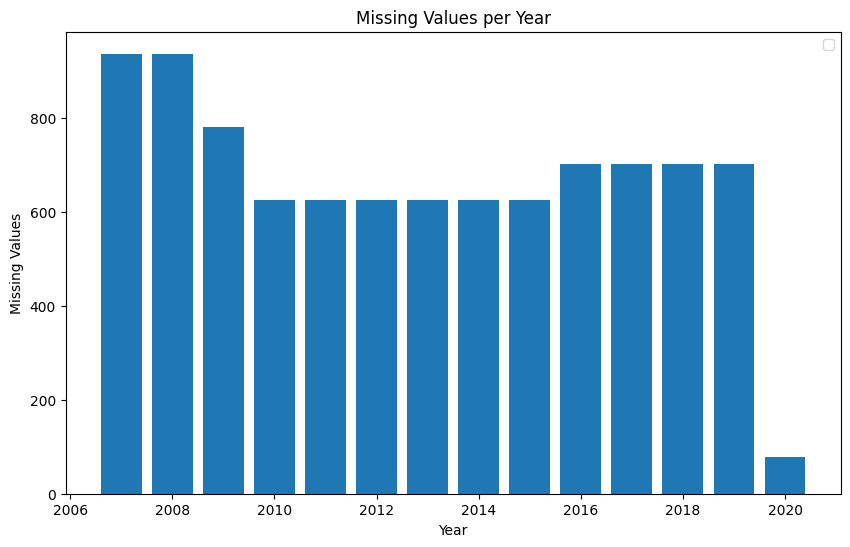

In [225]:
missing_values_per_year = list()
for i in range(2007, 2021):
    missing_values_per_year.append(len(df[df['ipc'].isna()][df['year']==i]))

plt.figure(figsize=(10, 6))
plt.bar(range(2007,2021), missing_values_per_year)
plt.xlabel('Year')
plt.ylabel('Missing Values')
plt.title('Missing Values per Year')
plt.legend()
plt.show()

In [226]:
df_rain = pd.read_csv(data_dir + "rainfall_monthly.csv") # Read data into DataFrame
df_rain = df_rain.rename(columns={"Unnamed: 0": "Year"})
df_rain = df_rain[df_rain['Year']>2009][df_rain['Year']<2020].copy()
#df_rain = df_rain.set_index('Year')

C:\Users\20203171\AppData\Local\Temp\ipykernel_10652\299015305.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rain = df_rain[df_rain['Year']>2009][df_rain['Year']<2020].copy()


In [227]:
df_rain

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
109,2010,4.16,10.77,44.88,58.65,100.25,147.98,191.69,167.16,124.59,121.54,23.81,9.18
110,2011,2.32,3.95,37.01,65.57,129.66,121.26,154.40,179.05,155.19,96.49,25.71,4.54
111,2012,3.66,4.21,27.54,65.76,119.74,131.82,166.32,180.34,143.83,99.38,25.64,11.27
112,2013,3.76,6.93,27.81,65.64,116.72,125.47,159.58,198.95,142.56,100.75,24.88,4.58
113,2014,3.31,6.68,28.51,79.16,122.70,138.16,166.56,186.36,140.49,98.13,24.28,7.16
114,2015,3.50,7.67,27.79,62.37,112.06,136.71,161.73,181.89,136.56,107.24,25.80,6.88
115,2016,3.14,7.03,29.97,61.22,120.46,133.13,159.51,187.31,141.54,96.80,22.09,4.06
116,2017,3.00,7.57,29.42,72.27,122.05,139.59,170.12,181.71,147.37,93.96,22.21,3.64
117,2018,2.62,9.66,27.58,61.10,134.52,147.05,155.90,187.13,140.46,100.80,22.55,7.96
118,2019,4.62,6.89,25.42,64.90,114.97,148.29,178.72,187.83,146.82,133.82,27.14,9.32


Correlation: 0.2327673124400865


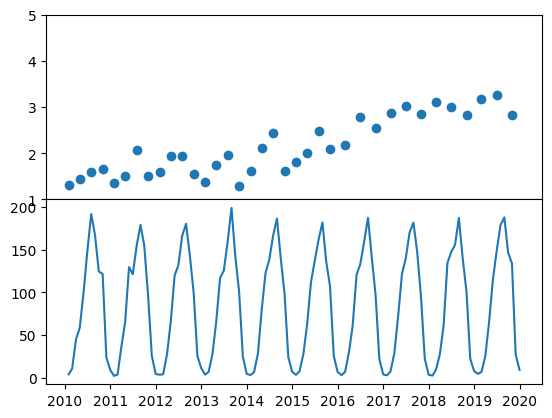

In [228]:
df_group = df['ipc'].groupby(level=0).mean()
rain = df_rain.set_index('Year').stack().values #values in one array instead of dataframe
df_group = np.array(df_group[36:156]) #only years 2010-2019

date_range = pd.date_range(start='2010-01-01', end='2019-12-31', freq='M')
# Create the DataFrame
df_1 = pd.DataFrame(data=df_group, index=date_range, columns=['IPC'])
df_2 = pd.DataFrame(data=rain, index=date_range, columns=['Rainfall'])
df_ = pd.concat([df_1, df_2], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].plot(date_range, df_['IPC'],marker='o')
axs[1].plot(date_range, df_['Rainfall'])
axs[0].set_ylim(1, 5);

correlation = df_['IPC'].corr(df_['Rainfall'])
print("Correlation:", correlation)


In [229]:
df_rain_lag = df_.copy()
df_rain_lag['Rainfall_Lag1'] = df_rain_lag['Rainfall'].shift(1)
df_rain_lag['Rainfall_Lag2'] = df_rain_lag['Rainfall'].shift(2)
df_rain_lag['Rainfall_Lag3'] = df_rain_lag['Rainfall'].shift(3)
df_rain_lag['Rainfall_Lag4'] = df_rain_lag['Rainfall'].shift(4)
df_rain_lag['Rainfall_Lag5'] = df_rain_lag['Rainfall'].shift(5)
df_rain_lag['Rainfall_Lag6'] = df_rain_lag['Rainfall'].shift(6)


correlation_nolag = df_rain_lag['IPC'].corr(df_rain_lag['Rainfall'])
correlation_lag1 = df_rain_lag['IPC'].corr(df_rain_lag['Rainfall_Lag1'])
correlation_lag2 = df_rain_lag['IPC'].corr(df_rain_lag['Rainfall_Lag2'])
correlation_lag3 = df_rain_lag['IPC'].corr(df_rain_lag['Rainfall_Lag3'])
correlation_lag4 = df_rain_lag['IPC'].corr(df_rain_lag['Rainfall_Lag4'])
correlation_lag5 = df_rain_lag['IPC'].corr(df_rain_lag['Rainfall_Lag5'])
correlation_lag6 = df_rain_lag['IPC'].corr(df_rain_lag['Rainfall_Lag6'])


print(correlation_nolag,correlation_lag1,correlation_lag2,correlation_lag3,correlation_lag4,correlation_lag5,correlation_lag6)

df_rain_lag.head(20)

0.2327673124400865 0.14457841225567455 -0.00872695537166225 -0.22363814410608512 -0.2363052070777404 -0.22202337051148888 -0.18330733519673


,IPC,Rainfall,Rainfall_Lag1,Rainfall_Lag2,Rainfall_Lag3,Rainfall_Lag4,Rainfall_Lag5,Rainfall_Lag6
2010-01-31,1.320513,4.16,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-28,NaN,10.77,4.16,NaN,NaN,NaN,NaN,NaN
2010-03-31,NaN,44.88,10.77,4.16,NaN,NaN,NaN,NaN
2010-04-30,1.448718,58.65,44.88,10.77,4.16,NaN,NaN,NaN
2010-05-31,NaN,100.25,58.65,44.88,10.77,4.16,NaN,NaN
2010-06-30,NaN,147.98,100.25,58.65,44.88,10.77,4.16,NaN
2010-07-31,1.602564,191.69,147.98,100.25,58.65,44.88,10.77,4.16
2010-08-31,NaN,167.16,191.69,147.98,100.25,58.65,44.88,10.77
2010-09-30,NaN,124.59,167.16,191.69,147.98,100.25,58.65,44.88
2010-10-31,1.653846,121.54,124.59,167.16,191.69,147.98,100.25,58.65


In [230]:
df.head()

,,country,district_code,centx,centy,year_month,year,month,ipc,ha,ndvi_mean,...,et_mean,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct
date,district,,,,,,,,,,,,,,,,,,,,,
2007-01-01,Bor,South Sudan,74,32.00486,6.465644,2007_01,2007,1,NaN,NaN,0.345851,...,0.671249,0.048880,0,0,0.561363,14008.33,7.961984,239344.0,11393.76,90.8503
2007-02-01,Bor,South Sudan,74,32.00486,6.465644,2007_02,2007,2,NaN,NaN,0.307600,...,0.129184,-0.457928,0,0,0.565693,14008.33,7.961984,239344.0,11393.76,90.8503
2007-03-01,Bor,South Sudan,74,32.00486,6.465644,2007_03,2007,3,NaN,NaN,0.278344,...,1.025460,-0.590175,0,0,0.592437,14008.33,7.961984,239344.0,11393.76,90.8503
2007-04-01,Bor,South Sudan,74,32.00486,6.465644,2007_04,2007,4,NaN,NaN,0.303320,...,3.846809,-1.845536,0,0,0.605352,14008.33,7.961984,239344.0,11393.76,90.8503
2007-05-01,Bor,South Sudan,74,32.00486,6.465644,2007_05,2007,5,NaN,NaN,0.413716,...,8.316274,-2.972735,0,0,0.618699,14008.33,7.961984,239344.0,11393.76,90.8503


In [231]:
df_ndvi_lag = df[['ipc','ndvi_mean']].groupby(level=0).mean()
df_ndvi_lag = df_ndvi_lag[36:156] #only years 2010-2019
df_ndvi_lag.head()

df_ndvi_lag['ndvi_Lag1'] = df_ndvi_lag['ndvi_mean'].shift(1)
df_ndvi_lag['ndvi_Lag2'] = df_ndvi_lag['ndvi_mean'].shift(2)
df_ndvi_lag['ndvi_Lag3'] = df_ndvi_lag['ndvi_mean'].shift(3)
df_ndvi_lag['ndvi_Lag4'] = df_ndvi_lag['ndvi_mean'].shift(4)
df_ndvi_lag['ndvi_Lag5'] = df_ndvi_lag['ndvi_mean'].shift(5)
df_ndvi_lag['ndvi_Lag6'] = df_ndvi_lag['ndvi_mean'].shift(6)


correlation_nolag = df_ndvi_lag['ipc'].corr(df_ndvi_lag['ndvi_mean'])
correlation_lag1 = df_ndvi_lag['ipc'].corr(df_ndvi_lag['ndvi_Lag1'])
correlation_lag2 = df_ndvi_lag['ipc'].corr(df_ndvi_lag['ndvi_Lag2'])
correlation_lag3 = df_ndvi_lag['ipc'].corr(df_ndvi_lag['ndvi_Lag3'])
correlation_lag4 = df_ndvi_lag['ipc'].corr(df_ndvi_lag['ndvi_Lag4'])
correlation_lag5 = df_ndvi_lag['ipc'].corr(df_ndvi_lag['ndvi_Lag5'])
correlation_lag6 = df_ndvi_lag['ipc'].corr(df_ndvi_lag['ndvi_Lag6'])


print(correlation_nolag,correlation_lag1,correlation_lag2,correlation_lag3,correlation_lag4,correlation_lag5,correlation_lag6)

df_ndvi_lag.head(20)

0.22787989791129695 0.013221275132125359 -0.13412406705471114 -0.13970426952598408 -0.2189130171103551 -0.21764869575732682 -0.07347735183999318


,ipc,ndvi_mean,ndvi_Lag1,ndvi_Lag2,ndvi_Lag3,ndvi_Lag4,ndvi_Lag5,ndvi_Lag6
date,,,,,,,,
2010-01-01,1.320513,0.323117,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-01,NaN,0.305371,0.323117,NaN,NaN,NaN,NaN,NaN
2010-03-01,NaN,0.324081,0.305371,0.323117,NaN,NaN,NaN,NaN
2010-04-01,1.448718,0.354451,0.324081,0.305371,0.323117,NaN,NaN,NaN
2010-05-01,NaN,0.486632,0.354451,0.324081,0.305371,0.323117,NaN,NaN
2010-06-01,NaN,0.581066,0.486632,0.354451,0.324081,0.305371,0.323117,NaN
2010-07-01,1.602564,0.682173,0.581066,0.486632,0.354451,0.324081,0.305371,0.323117
2010-08-01,NaN,0.708255,0.682173,0.581066,0.486632,0.354451,0.324081,0.305371
2010-09-01,NaN,0.684392,0.708255,0.682173,0.581066,0.486632,0.354451,0.324081


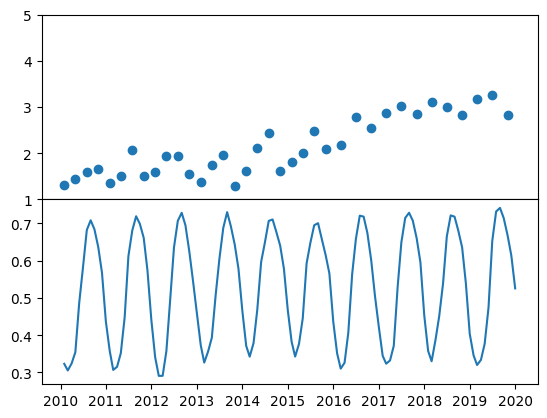

In [232]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].plot(date_range, df_ndvi_lag['ipc'],marker='o')
axs[1].plot(date_range, df_ndvi_lag['ndvi_mean'])
axs[0].set_ylim(1, 5);

In [233]:
df_copy = df_.copy()
df_copy['ndvi'] = np.array(df_ndvi_lag['ndvi_mean'])
print("Correlation:", df_copy['ndvi'].corr(df_copy['Rainfall']))
df_copy

Correlation: 0.851518008275929


,IPC,Rainfall,ndvi
2010-01-31,1.320513,4.16,0.323117
2010-02-28,NaN,10.77,0.305371
2010-03-31,NaN,44.88,0.324081
2010-04-30,1.448718,58.65,0.354451
2010-05-31,NaN,100.25,0.486632
...,...,...,...
2019-08-31,NaN,187.83,0.741587
2019-09-30,NaN,146.82,0.714093
2019-10-31,2.820513,133.82,0.667978
2019-11-30,NaN,27.14,0.613833
